<a href="https://colab.research.google.com/github/jyeoum/BiologicallyIntelligentExploration/blob/main/Copy_of_Homework3_CBGT_and_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/CoAxLab/BiologicallyIntelligentExploration/blob/main/Homework/Homework3-CBGT_and_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 3: CBGT decision-making and information concepts**

## Getting started

This homework will involve concepts from the labs we've gone over in class. Feel free to reference them as you complete the assignment.

This homework contains 2 sections:
1. Simulating decisions in the CBGT network uner stronger direct vs indirect pathway gain.
1. Investigating information-seeking agents in environments of varying information noise.

Fill out the code cells below and answer the questions to complete the assignment. Most of the programming is quite straightforward, as it is all based on code from the labs, which you can use/modify in this notebook.


---
## Part 1 - CBGT decision simulations [51 pt]

Here you will be adapting the Lab 5 code so that you increase the indirect *and* direct pathways gains by 33% (we did 10% in class). This will give a clearer visualization of how these two pathways control the overall reaction times when you plot their joint histogram.


In the code cells below, fill in (and run) code according to the text instructions before each one. Refer to lab 5 for help.

#### Change Colab's working directory to the `/content` folder using the `cd` command

In [25]:
cd /content

/content


#### Clone in the CBGT library from https://github.com/CoAxLab/CBGT

In [26]:
!git clone https://github.com/CoAxLab/CBGT

Cloning into 'CBGT'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 592 (delta 1), reused 0 (delta 0), pack-reused 581
Receiving objects: 100% (592/592), 13.84 MiB | 24.51 MiB/s, done.
Resolving deltas: 100% (313/313), done.


#### Change Colab's working directory to the `/content/CBGT` folder

In [27]:
cd /content/CBGT

/content/CBGT


#### Import the necessary modules

In [28]:
# import libraries and configure plots

import os, sys
import pandas as pd
import numpy as np
import random
from future.utils import listvalues
from copy import deepcopy

import cbgt.netgen as ng
import cbgt.analyzefx as afx
from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', rc=rc, font_scale=1.4)

#### Specify the saving directory and set default model parameters/weights exactly as we did in the CBGT lab.

In [29]:
# specify saving directory

parentDir = 'cbgtDemoTEST'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)

# specify certain model parameters

BaseStim = 0
Stim = 2.54
Dynamic = 30.0
Choices = 2
rampingCTX = True
popscale = .3
Start=200

# save dMSN/iMSN weight presets for each choice

presetLow = ng.set_post_learning_weights(dMSN=[1.01, 0.99], iMSN=[1.0,1.0])
presetHi = ng.set_post_learning_weights(dMSN=[1.03, 0.98], iMSN=[1.0,1.0])
presets = [presetLow, presetHi]

conds = ['low', 'high']
condABC = ['a', 'b']
cond12 = [1, 2]

savedirs = [os.path.join(savedir, c) for c in conds]
saveLow, saveHi = savedirs
saveTest=os.path.join(savedir, 'test')

presetDict = dict(zip(conds, presets))
condOrder = dict(zip(conds, condABC))
condLevel = dict(zip(conds+['test'], cond12+[0]))

#### Define the helping functions for getting sampling parameters, sampling region activations, and building a single network.

In [30]:
# helper functions to specify connection efficiacies for certain pathways

def get_sampling_params(scale, direct_strength, indirect_strength):
    
    # set strengths of background inputs/currents
    CxSTR      =    0.2
    CxTh       =    0.03
    CxFSI      =    0.165
    D1STR_GPi  =    direct_strength * 1.10
    D2STR_GPeP =    indirect_strength * 1.65
    STN_GPeP_A =    0.07
    STN_GPeP_N =    4.01
    STN_GPi    =    0.04 
    GPi_Th     =    0.067
    ThSTR      =    0.34
    ThCx       =    0.02

    mu = dict(Cx={'STR':CxSTR, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STR':ThSTR, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi},
                D2STR={'GPeP': D2STR_GPeP},
                STN={'GPi': STN_GPi},
                GPi={'Th': GPi_Th})
    sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd

# assign the background inputs to each brain region accordingly
def sample_network_efficacies(muEff, sdEff, N):
    X = {}
    nuclei = list(muEff)
    for i in nuclei:
        targets = list(muEff[i])
        X[i] = {}
        for j in targets:
            X[i][j] = np.random.normal(muEff[i][j], sdEff[i][j], N)
    return X

# build the network with specified connections
def build_single_network(X, idx=0):
    
    Cx={'STR': X['Cx']['STR'][idx], 
        'Th': X['Cx']['Th'][idx], 
        'FSI': X['Cx']['FSI'][idx]}
    
    D1STR={'GPi': X['D1STR']['GPi'][idx]}
    D2STR={'GPeP': X['D2STR']['GPeP'][idx]}
    
    STN={'GPi': X['STN']['GPi'][idx]}
    
    GPi={'Th': X['GPi']['Th'][idx]}
    
    Th={'STR': X['Th']['STR'][idx], 
        'Cx': X['Th']['Cx'][idx]}

    return ng.getConEff(Cx=Cx, D1STR=D1STR, D2STR=D2STR, STN=STN, GPi=GPi, Th=Th)

#### Code for defining the function for running a batch of simulations.

In [31]:
# code to run a batch of simulations

def runBatch(batch_size, direct_strength, indirect_strength, parallel = 1):
  N_subj = 1
  sdScale = 0

  conProb = ng.getConProb()
  muEff, sdEff = get_sampling_params(sdScale, direct_strength, indirect_strength)
  X = sample_network_efficacies(muEff, sdEff, N=N_subj)
  subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]
  idx = 0
  conEff_i = subj_eff_dicts[idx]

  stim = 2.5
  preset = presetDict['low']

  ng.setDirectory(saveTest)

  np.random.seed(seed=np.random.randint(0,1000))
  sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                                popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                                WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                                rampingCTX=True,
                                conProb=conProb, 
                                conEff=conEff_i)

  ng.compileAndRunSweepALL(batch_size, 0, 1, parallel)

#### Define the helper function for compiling simulated behavioral data into a dataframe.

In [32]:
# code to compile the behavioral data into a dataframe

def readResults(batch_size):
    results = ng.readAllTrialResults(batch_size,0,1)
    rtdata = pd.DataFrame(columns=['rt','accuracy'])
    for result in results[0][:batch_size]:
        temp = ng.findOutputs(result)['decision made']
        row = pd.Series({'rt':temp['delay'], 'accuracy':(1-temp['pathvals'][0])})
        rtdata = rtdata.append(row, ignore_index=True)
    return rtdata

### Code for running your specific batches of simulations

#### Set up your batch run parameters with a `batch_size` of 20, with `direct_strength` increased 33% from the default 1.00, and with the standard `indirect_strength` setting of 1.00. [7 pt]

In [33]:
# code to set batch parameters
batch_size = 20
direct_strength = 1.33
indirect_strength = 1.00

#### Run the strengthened direct pathway batch and produce a corresponding dataframe [7 pt]

In [34]:
# code to run batch
runBatch(batch_size, direct_strength, indirect_strength)

# code to produce dataframe
rt_data_direct_up = readResults(batch_size)
rt_data_direct_up

,rt,accuracy
0,257.009491,0.0
1,277.010712,0.0
2,252.009186,1.0
3,285.011200,1.0
4,251.009125,1.0
5,250.009064,1.0
6,257.009491,1.0
7,282.011017,1.0
8,246.008820,1.0
9,239.008392,1.0


#### Set up your batch run parameters with a `batch_size` of 20, the standard `direct_strength` of 1.00, but with `indirect_strength` increased by 33%. [7 pt]

In [35]:
# code to set batch parameters
batch_size = 20
direct_strength = 1.00
indirect_strength = 1.33

#### Run the strengthened indirect pathway batch and produce a corresponding dataframe [7 pt]

In [43]:
# code to run batch
runBatch(batch_size, direct_strength, indirect_strength)

# code to produce dataframe
rt_data_indirect_up = readResults(batch_size)
rt_data_indirect_up

TypeError: ignored

#### For each condition (strengthened direct vs indirect pathway), calculate and print the mean values for *reaction time* and *percent of actions made to the left* ("accuracy") [5 pt]

In [36]:
# code to calculate the mean values for reaction time and accuracy for each condition
print('Strengthened direct pathway mean values:')
print(rt_data_direct_up.mean())
print()

print('Strengthened indirect pathway mean values:')
print(rt_data_indirect_up.mean())

Strengthened direct pathway mean values:
rt          259.159622
accuracy      0.800000
dtype: float64

Strengthened indirect pathway mean values:


NameError: ignored

#### Plot a histogram of reaction times for the strengthened direct vs. indirect pathway conditions. Make sure to refer to the correct data and include the correct data each time you call the `plt.hist()` function. [6 pt]

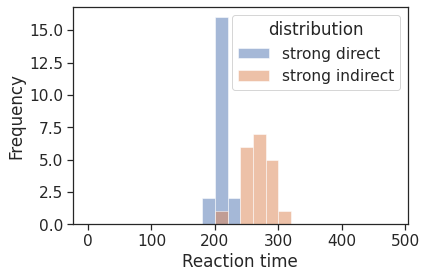

In [35]:
# code to plot histogram of reaction times for each condition
plt.hist(rt_data_direct_up.rt, bins=np.arange(0,500,20), alpha=0.5, label='strong direct')
plt.hist(rt_data_indirect_up.rt, bins=np.arange(0,500,20), alpha=0.5, label='strong indirect')
plt.xlabel('Reaction time')
plt.ylabel('Frequency')
plt.legend(title='distribution')


### Question 1.1 [6 pt]

How what does increasing the relative efficacy of the direct and indirect pathways do to the networks' decision speed? Explain why this occurs.


In [2]:
# Increasing the relative efficacy of the direct pathway decreases the network's decision speed, and increasing the relative efficacy of the indirect
# pathway increases the network's decision speed. The decreased decision speed in the direct pathway can be attributed to the fewer steps needed to
# disinhibit the thalamus (directly inhibit the GPi). The indirect pathway thus takes longer to decide because it takes more steps to disinhibit the
# thalamus (inhibition of GPe instead).

### Question 1.2: [6 pt]
Rerun the simulations above but increase the synaptic weight from STN to GPi from 0.0324 to 0.04. How does this influence the outcome of the simulations? Why does this happen?

(Hint: if you get an error while running the simulations, this is supposed to happen).

In [1]:
# The code for the strengthened indirect pathway batch doesn't run. Increasing the synaptic weight from STN to GPi would increase the strength of the
# excitatory signals from STN onto GPi, which would thus result in an inhibitory signal onto the thalamus and prevent a decision from being made. This
# would explain why running the simulation results in an error specifically for the strengthened indirect pathway as the strengthened direct pathway
# bypasses this strengthened inhibitory signal onto the thalamus.


---
## Part 2 - Exploration agents in information-distorted environments [49 pt]

In the last part of Lab 6 we saw how the distortion in the channel driven by *missing information* influenced the efficiency of our Info agent. In this second part of the homework, you will investigate the effect of distortion driven by *sensor noise*.

Here we will test a range of *noise_sigma* (as opposed to *p_scent*) values. Essentially we will be turning *up* the distortion as *noise_sigma* increases. For these experiments we will hold the *p_scent* constant at 0.1 (a sparse information environment).

### Coding

In the code cells below, fill in (and run) code according to the text instructions before each one. Refer to lab 6 for help.

#### Install relevant code libraries.

In [3]:
!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/coaxlab/explorationlib to /tmp/pip-req-build-zv17j5c4
  Running command git clone -q https://github.com/coaxlab/explorationlib /tmp/pip-req-build-zv17j5c4
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=24680 sha256=c02bf54b395bc718d0eb483008d1c8785d09d32e5cc52d90b0538f7c1e4454cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-en0x7i8p/wheels/33/38/07/7f61d2c279b8eed0cbef923c5315580ce93146145ca01ca407
Successfully built explorationlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-i2haz7tq
  Running command git clone -q https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-i2haz7tq
     |████████████████████████████████| 21.8 MB 85.3 MB/s 
  Created wheel for gym-maze: filename=gym_maze

#### Import relevant modules.

In [4]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import explorationlib
from explorationlib.local_gym import ScentGrid

from explorationlib.agent import DiffusionGrid
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import AccumulatorInfoGrid

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import add_noise
from explorationlib.local_gym import create_grid_scent_patches

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

from explorationlib.score import total_reward
from explorationlib.score import num_death

#### Set up pretty plots.

In [5]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

### Code for running your experiments

We've provided some code below with *p_scent* set at the sparse-information value of 0.1. We also provide a range of *noise_sigma* that you will use. The range is on an exponential scale, just because it makes sense given that *noise_sigma* can only be 0 or greater.

In [6]:
# Our parameters 
p_scent = 0.1
noise_sigmas = [0.5625, 0.75, 1, 1.33, 1.77] # range of values on an exp. scale

# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = noise_sigmas # list(range(5))

#### Complete the code below and run your experiments. We've specified the default parameters for the agent and environment below. Fill in the code for running experiments at each *noise_sigma* value within the loop below. (Add your code where it says `# ADD YOUR EXPERIMENT CODE HERE - BE SURE TO CHECK INDENTATION`.) [7 pt]

In [17]:
# Define the accumulation parameters
drift_rate = 1.0
threshold = 1.5
accumulate_sigma = 1.0

# Shared 
num_experiments = 100
num_steps = 400
seed_value = 5838

# Define non-scent probability values
amplitude = 1
detection_radius = 1
max_steps = 1
min_length = 1
num_targets = 50
target_boundary = (10, 10)

# How many experiments to run
num_experiments = 100

# Infotaxis agent
info = AccumulatorInfoGrid(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=drift_rate, 
    threshold=threshold,
    accumulate_sigma=1
)
info.seed(seed_value)

# Run
results = []

for i, noise_sigma in zip(names, noise_sigmas):
  # targets
  prng = np.random.RandomState(seed_value)
  targets = uniform_targets(num_targets, target_boundary, prng=prng)
  values = constant_values(targets, 1)

  # scents
  scents = []
  for _ in range(len(targets)):
      coord, scent = create_grid_scent_patches(
          target_boundary, p=p_scent, amplitude=amplitude, sigma=noise_sigma)
      scents.append(scent)

  # env
  env = ScentGrid(mode=None)
  env.seed(seed_value)
  env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

  exp = experiment(
      f"info",
      info,
      env,
      num_steps=num_steps,
      num_experiments=num_experiments,
      dump=False,
      split_state=True,
      seed=seed_value
  )

  results.append(exp)

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

#### Add in code below to plot the bumber of deaths for different values of *noise_sigma*. Make sure your x-axis is labeled with noise_sigma, not p_scent. [6 pt]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

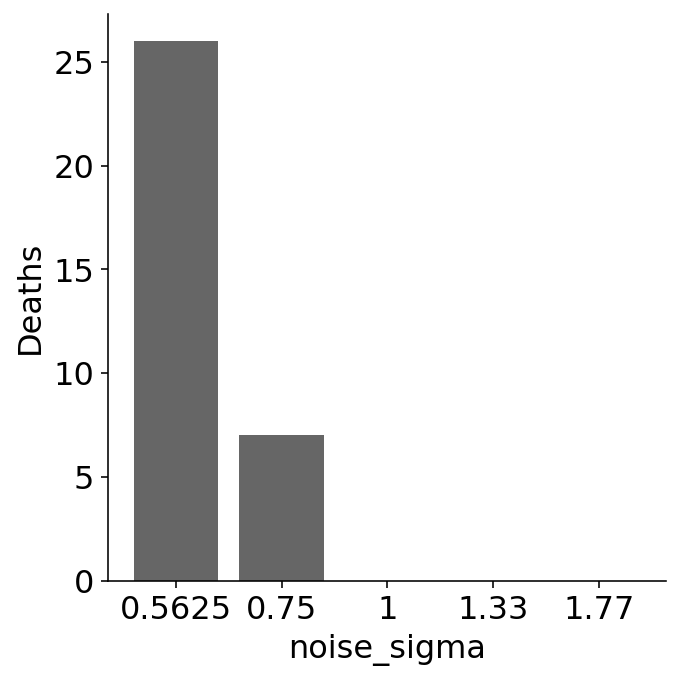

In [18]:
# code to plot number of deaths for different values of noise_sigma
scores = []
for result in results:
    scores.append(num_death(result))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("noise_sigma")
plt.tight_layout()
sns.despine()

#### Add in code below to plot max score for different values of *noise_sigma*. Make sure your x-axis is labeled with noise_sigma, not p_scent. [6 pt]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

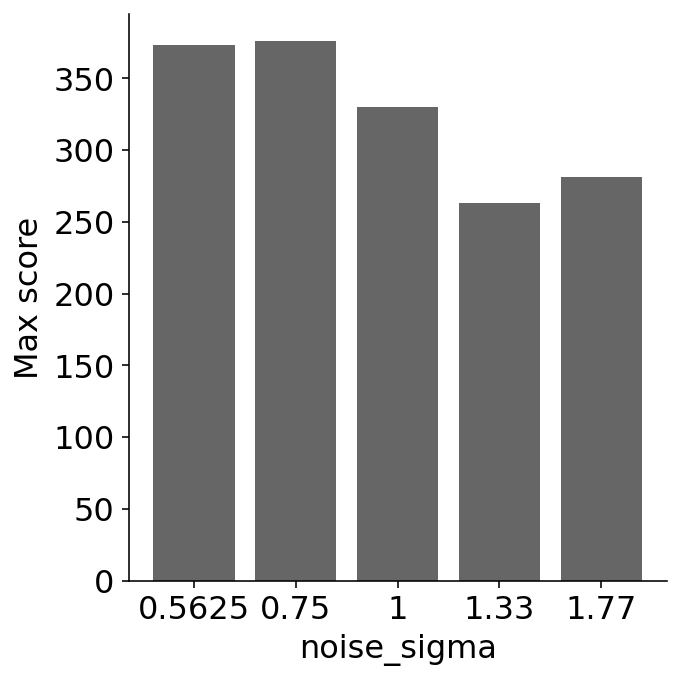

In [19]:
# code for max score for different values of noise_sigma
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# tabulate
m = []
for score in scores:
    m.append(np.max(score))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Max score")
plt.xlabel("noise_sigma")
plt.tight_layout()
sns.despine()

#### Add in code below to plot average score and score frequency distributions for different values of *noise_sigma*. Make sure your x-axes are labeled with noise_sigma, not p_scent. [6 pt]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

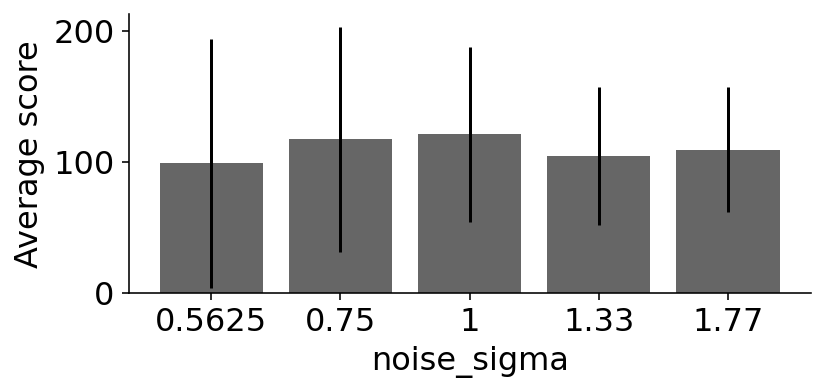

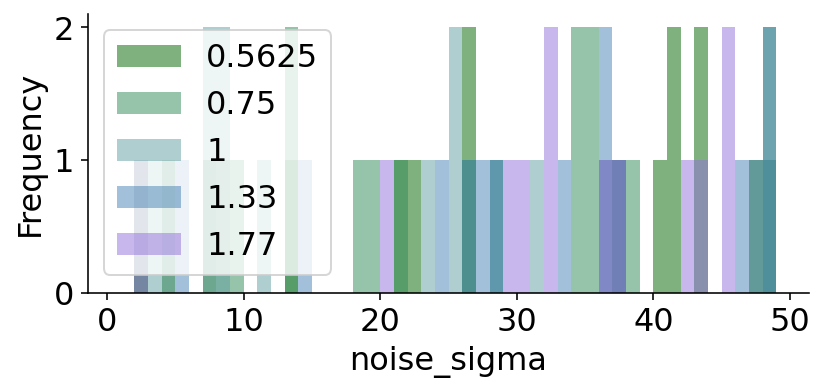

In [20]:
# score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# tabulate
m, sd = [], []
for score in scores:
    m.append(np.mean(score))
    sd.append(np.std(score))

# plot means
fig = plt.figure(figsize=(6, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Average score")
plt.xlabel("noise_sigma")
plt.tight_layout()
sns.despine()

# dists of means
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.ylabel("Frequency")
    plt.xlabel("noise_sigma")
    plt.tight_layout()
    sns.despine()

### Question 2.1 [8 pt]

How does increasing *noise_sigma* impact our Info agent's performance? Explain why this particular pattern emerges in the results.

In [23]:
# As noise_sigma increases, the agent's performance increases. This pattern could be due to how the agent extracts the signal from the noise: with
# more noise, the signal has to be stronger to overcome the increased distortion. As a result, stronger signals could be better indicators of the
# targets said agent is going after.

### Question 2.2 [8 pt]

Re-run the simulations from this section, but now change the drift-rate from 1.0 to 0.75. How and why does this influence the agent's behavior (compared to the higher drift-rate)?

In [22]:
# Regarding the number of deaths, all the agents across all 100 trials die when the noise_sigma is 0.5625 or 0.75, and the number of deaths
# increased noticeably across all noise_sigma conditions. The max score also changed across the agents, as those in the higher noise_sigma
# environment actually got higher max scores (1.33 specifically) than the ones in the middle/lowest one (1, considering they're the lowest
# noise_sigma condition that are still alive), which is the opposite of when the drift rate was 1.0. The deaths of the agents in the first
# two noise_sigma conditions could be due to their inability to accumulate enough evidence to make a decision as the signal and information
# they were receiving was too weak to contribute to a decisive outcome.

### Question 3.3 [8 pt]

Now set the drift-rate back to 1.0 and reduce the boundary height from 3.0 to 1.5. Re-run the simulations in again. How and why does this influence the agent's behavior (compared to the higher boundary height)?

In [21]:
# When the boundary height was reduced from 3.0 to 1.5, the number of deaths decreased significantly across all sigma_noise conditions, with
# there being no deaths in the last three highest noise_sigma conditions. The two lowest noise_sigma conditions saw agents with the highest
# scores, with the max scores being slightly lower than when the boundary height was higher. With the lowered boundary height, on average the
# agents scored similarly and at similar frequencies across all noise_sigma conditions. This could be due to there being less evidence needed
# before the agent makes the decision to go a certain direction, which makes them more likely to head in the direction of a target based on the
# strength of the perceived signal.

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Write Name(s) here*

**DUE:** 5pm ET, Oct. 28, 2022. Email the link to the completed notebook on your Github repository to the TA and me via Canvas.